In [ ]:
# %env SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
# %env LIBSUMO_AS_TRACI=1
# %env PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


env: SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
env: LIBSUMO_AS_TRACI=1
env: PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


In [2]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import sys
import matplotlib.pyplot as plt

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from env import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_observation import CustomEmergencyObservationFunction
from custom_reward import emergency_reward_fn

/Users/atharva/Documents/CSE/RL/rl-final/ve/lib/python3.9/site-packages/traci/__init__.py:41: UserWarning: Could not import libsumo, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo, falling back to pure python traci (%s)." % e)


In [3]:
class DQNetwork(nn.Module):
    def __init__(self, inp_size, op_size):
        super(DQNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.hl1 = nn.Linear(inp_size, 128)
        self.hl2 = nn.Linear(128, 128)
        self.fc = nn.Linear(128, op_size)
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.hl1.weight)
        torch.nn.init.xavier_normal_(self.hl2.weight)
        torch.nn.init.xavier_normal_(self.fc.weight)
        torch.nn.init.zeros_(self.hl1.bias)
        torch.nn.init.zeros_(self.hl2.bias)
        torch.nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = self.hl1(x)
        x = self.activation(x)
        x = self.hl2(x)
        x = self.activation(x)
        x = self.fc(x)
        return x

In [4]:
class GreedyAgent:
    
    def __init__(self, model, env, initial_epsilon, epsilon_decay, final_epsilon, discount_factor, num_episodes=1000):
        self.env = env
        self.model = model
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
    def step(self, obs, train=True):
        if train:
            if np.random.random() < self.epsilon:
                return self.action_space.sample()
            else:
                self.model.eval()
                with torch.no_grad():
                    output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                    return torch.argmax(output).item()
        else:
            self.model.eval()
            with torch.no_grad():
                output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                return torch.argmax(output).item()
        

    def decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

In [5]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=False,
        num_seconds=500,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [6]:
# training params
BUFFER_SIZE = 500
batch_size = 32
sync_target_step = 300
train_every_step = 1
episodes = 200
replay_buffer = torch.zeros((BUFFER_SIZE, 12 + 1 + 1 + 12 + 1), dtype = torch.float32) #[sx9, a, r, s'x9, terminate flag]
learning_rate = 0.01

#agent params
start_epsilon = 1
final_epsilon = 0.01
epsilon_decay = (final_epsilon/start_epsilon)**(1/episodes)  # exponential decay
discount_factor = 0.99

# model init
# print(env.observation_space.shape[0])

model = DQNetwork(12, env.action_space.n)
target_model = deepcopy(model)
# m = torch.load("./pthbackup/emergency_dqn.pth")
# model.load_state_dict(m)
agent = GreedyAgent(model, env, start_epsilon, epsilon_decay, final_epsilon, discount_factor)

# optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [7]:
n_iters = 0 
train_loss = []
reward_per_episode = [0] * episodes
epsilon_per_episode = [0] * episodes
steps_per_episode = [0] * episodes
wait_per_episode_lane_1 = [0] * episodes
wait_per_episode_lane_2 = [0] * episodes
for episode in range(episodes):
    print("Episode: ", episode)
    obs = env.reset()
    done = {"__all__": False}
    epsilon_per_episode[episode] = agent.epsilon
    batch_loss = []
    t = 0
    lane_1_wt, lane_2_wt = 0, 0
    while not done["__all__"]:
        action = agent.step(obs)
        next_obs, reward, done, info = env.step({'t': action})

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v
        
        n_iters = n_iters + 1
        
        reward_per_episode[episode] += reward['t']
        replay_buffer[n_iters % BUFFER_SIZE] = torch.cat([torch.from_numpy(obs['t']), torch.tensor([action], dtype=torch.int32), torch.tensor([reward['t']], dtype=torch.int32), torch.from_numpy(next_obs['t']), torch.tensor([int(done["__all__"])], dtype=torch.int32)]).to(torch.float32)
        # print((next_obs['t'].shape))
        obs = deepcopy(next_obs)
        t += 1
    
    steps_per_episode[episode] += t
    agent.decay()
    env.close()
    
    if n_iters >= batch_size and episode % train_every_step == 0:

        selected_transition_indices = torch.randint(low=0, high=min(n_iters, BUFFER_SIZE), size=(batch_size, ))
        selected_transition = replay_buffer[selected_transition_indices]  #selected_transition: [sx9, a, r, s'x9, terminate flag]

        td_target = torch.zeros(batch_size)
        next_obs = selected_transition[:, 14:-1]
        target_model.eval()
        with torch.no_grad():
            target_output = target_model(next_obs)
            q_values, _ = torch.max(target_output, dim = 1)
            td_target = torch.where(selected_transition[:, -1] == True, selected_transition[:, 13], selected_transition[:, 13] + discount_factor * q_values)

        model.train()
        obs = selected_transition[:, :12]
        output = model(obs)
        td_estimate = output.gather(1, selected_transition[:, 12][:, None].type(torch.int64)).squeeze(1)
        loss = criterion(td_target, td_estimate)

        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(episode % sync_target_step == 0):
        target_model.load_state_dict(model.state_dict())

 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 322 ACT 40 BUF 33)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 321 ACT 40 BUF 52)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 314 ACT 37 BUF 50)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 314 ACT 41 BUF 30)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 360 ACT 36 BUF 17)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 325 ACT 40 BUF 29)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 338 ACT 32 BUF 25)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 336 ACT 39 BUF 15)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 340 ACT 35 BUF 6)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 319 ACT 32 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~44000.00UPS, TraCI: 17ms, vehicles TOT 300 ACT 44 BUF 62
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 359 ACT 45 BUF 6)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 264 ACT 42 BUF 85)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 311 ACT 38 BUF 46)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 267 ACT 41 BUF 78)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 307 ACT 42 BUF 49)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 274 ACT 42 BUF 99)                
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~41000.00UPS, TraCI: 19ms, vehicles TOT 273 ACT 41 BUF 77
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 273 ACT 41 BUF 99)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 258 ACT 42 BUF 110)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 254 ACT 38 BUF 99)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 249 ACT 32 BUF 121)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 222 ACT 41 BUF 123)               
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~30000.00UPS, TraCI: 13ms, vehicles TOT 351 ACT 30 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 348 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 353 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 362 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 358 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 354 ACT 48 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 387 ACT 39 BUF 1)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 337 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 365 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 347 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 329 ACT 20 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 27ms, vehicles TOT 358 ACT 57 BUF 4)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 343 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 344 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 364 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 338 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 362 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 28ms, vehicles TOT 374 ACT 67 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 364 ACT 51 BUF 11)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 364 ACT 32 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 356 ACT 50 BUF 5)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 348 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 362 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 333 ACT 43 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 368 ACT 33 BUF 8)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~40000.00UPS, TraCI: 17ms, vehicles TOT 302 ACT 40 BUF 48
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 207 ACT 40 BUF 149)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 213 ACT 44 BUF 119)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 191 ACT 44 BUF 134)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 213 ACT 40 BUF 133)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 228 ACT 45 BUF 166)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 316 ACT 42 BUF 38)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 371 ACT 40 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 336 ACT 49 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 357 ACT 48 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 348 ACT 47 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 336 ACT 50 BUF 34)                
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~37000.00UPS, TraCI: 16ms, vehicles TOT 357 ACT 37 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 346 ACT 53 BUF 9)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 348 ACT 50 BUF 20)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 339 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 352 ACT 41 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~42000.00UPS, TraCI: 18ms, vehicles TOT 329 ACT 42 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 347 ACT 57 BUF 33)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 342 ACT 56 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 358 ACT 52 BUF 3)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~62000.00UPS, TraCI: 27ms, vehicles TOT 371 ACT 62 BUF 3)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 337 ACT 55 BUF 38)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 342 ACT 49 BUF 3)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 359 ACT 34 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 340 ACT 34 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 348 ACT 19 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 293 ACT 41 BUF 52)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 234 ACT 34 BUF 140)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 221 ACT 45 BUF 152)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 193 ACT 40 BUF 155)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 240 ACT 32 BUF 107)               
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 344 ACT 40 BUF 2)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 330 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 363 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~47000.00UPS, TraCI: 20ms, vehicles TOT 356 ACT 47 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 346 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 345 ACT 49 BUF 13)                
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~50000.00UPS, TraCI: 22ms, vehicles TOT 335 ACT 50 BUF 36
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 358 ACT 52 BUF 2)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~49000.00UPS, TraCI: 22ms, vehicles TOT 346 ACT 49 BUF 25
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 311 ACT 48 BUF 52)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 359 ACT 49 BUF 7)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 308 ACT 49 BUF 32)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 318 ACT 50 BUF 35)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 309 ACT 53 BUF 46)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 317 ACT 44 BUF 19)                
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 354 ACT 36 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 352 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 359 ACT 34 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 356 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 349 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 360 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 363 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 342 ACT 14 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 373 ACT 20 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 358 ACT 22 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 372 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 329 ACT 17 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~24000.00UPS, TraCI: 11ms, vehicles TOT 362 ACT 24 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 352 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 349 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 324 ACT 18 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 367 ACT 21 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 336 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 351 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 358 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 376 ACT 35 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 344 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 374 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 355 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 365 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 364 ACT 34 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 336 ACT 34 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 380 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 359 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 364 ACT 30 BUF 0)                 
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 373 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 351 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 365 ACT 36 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 353 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 352 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 329 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 319 ACT 18 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 347 ACT 19 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 364 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 352 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 353 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 367 ACT 17 BUF 0)                  
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 353 ACT 17 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 351 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 342 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 355 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 334 ACT 19 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 327 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~24000.00UPS, TraCI: 11ms, vehicles TOT 345 ACT 24 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 361 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 367 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 371 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 345 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 379 ACT 32 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 368 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 346 ACT 21 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 366 ACT 32 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 374 ACT 37 BUF 1)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 355 ACT 41 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 358 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 363 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 344 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 376 ACT 44 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 371 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 338 ACT 39 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 368 ACT 36 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 359 ACT 36 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~32000.00UPS, TraCI: 13ms, vehicles TOT 363 ACT 32 BUF 0)
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 371 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 369 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 361 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 341 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 329 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 340 ACT 21 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 341 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 360 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 388 ACT 37 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 352 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 372 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 344 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 351 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 364 ACT 27 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 356 ACT 28 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 345 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 345 ACT 21 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 368 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 321 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 332 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 353 ACT 22 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 356 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 340 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~21000.00UPS, TraCI: 9ms, vehicles TOT 324 ACT 21 BUF 0) 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 385 ACT 24 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 365 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 322 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 370 ACT 30 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 389 ACT 39 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 348 ACT 20 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 339 ACT 23 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 364 ACT 33 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 367 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 354 ACT 22 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 363 ACT 38 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 356 ACT 17 BUF 0)                  
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 338 ACT 25 BUF 0)                 


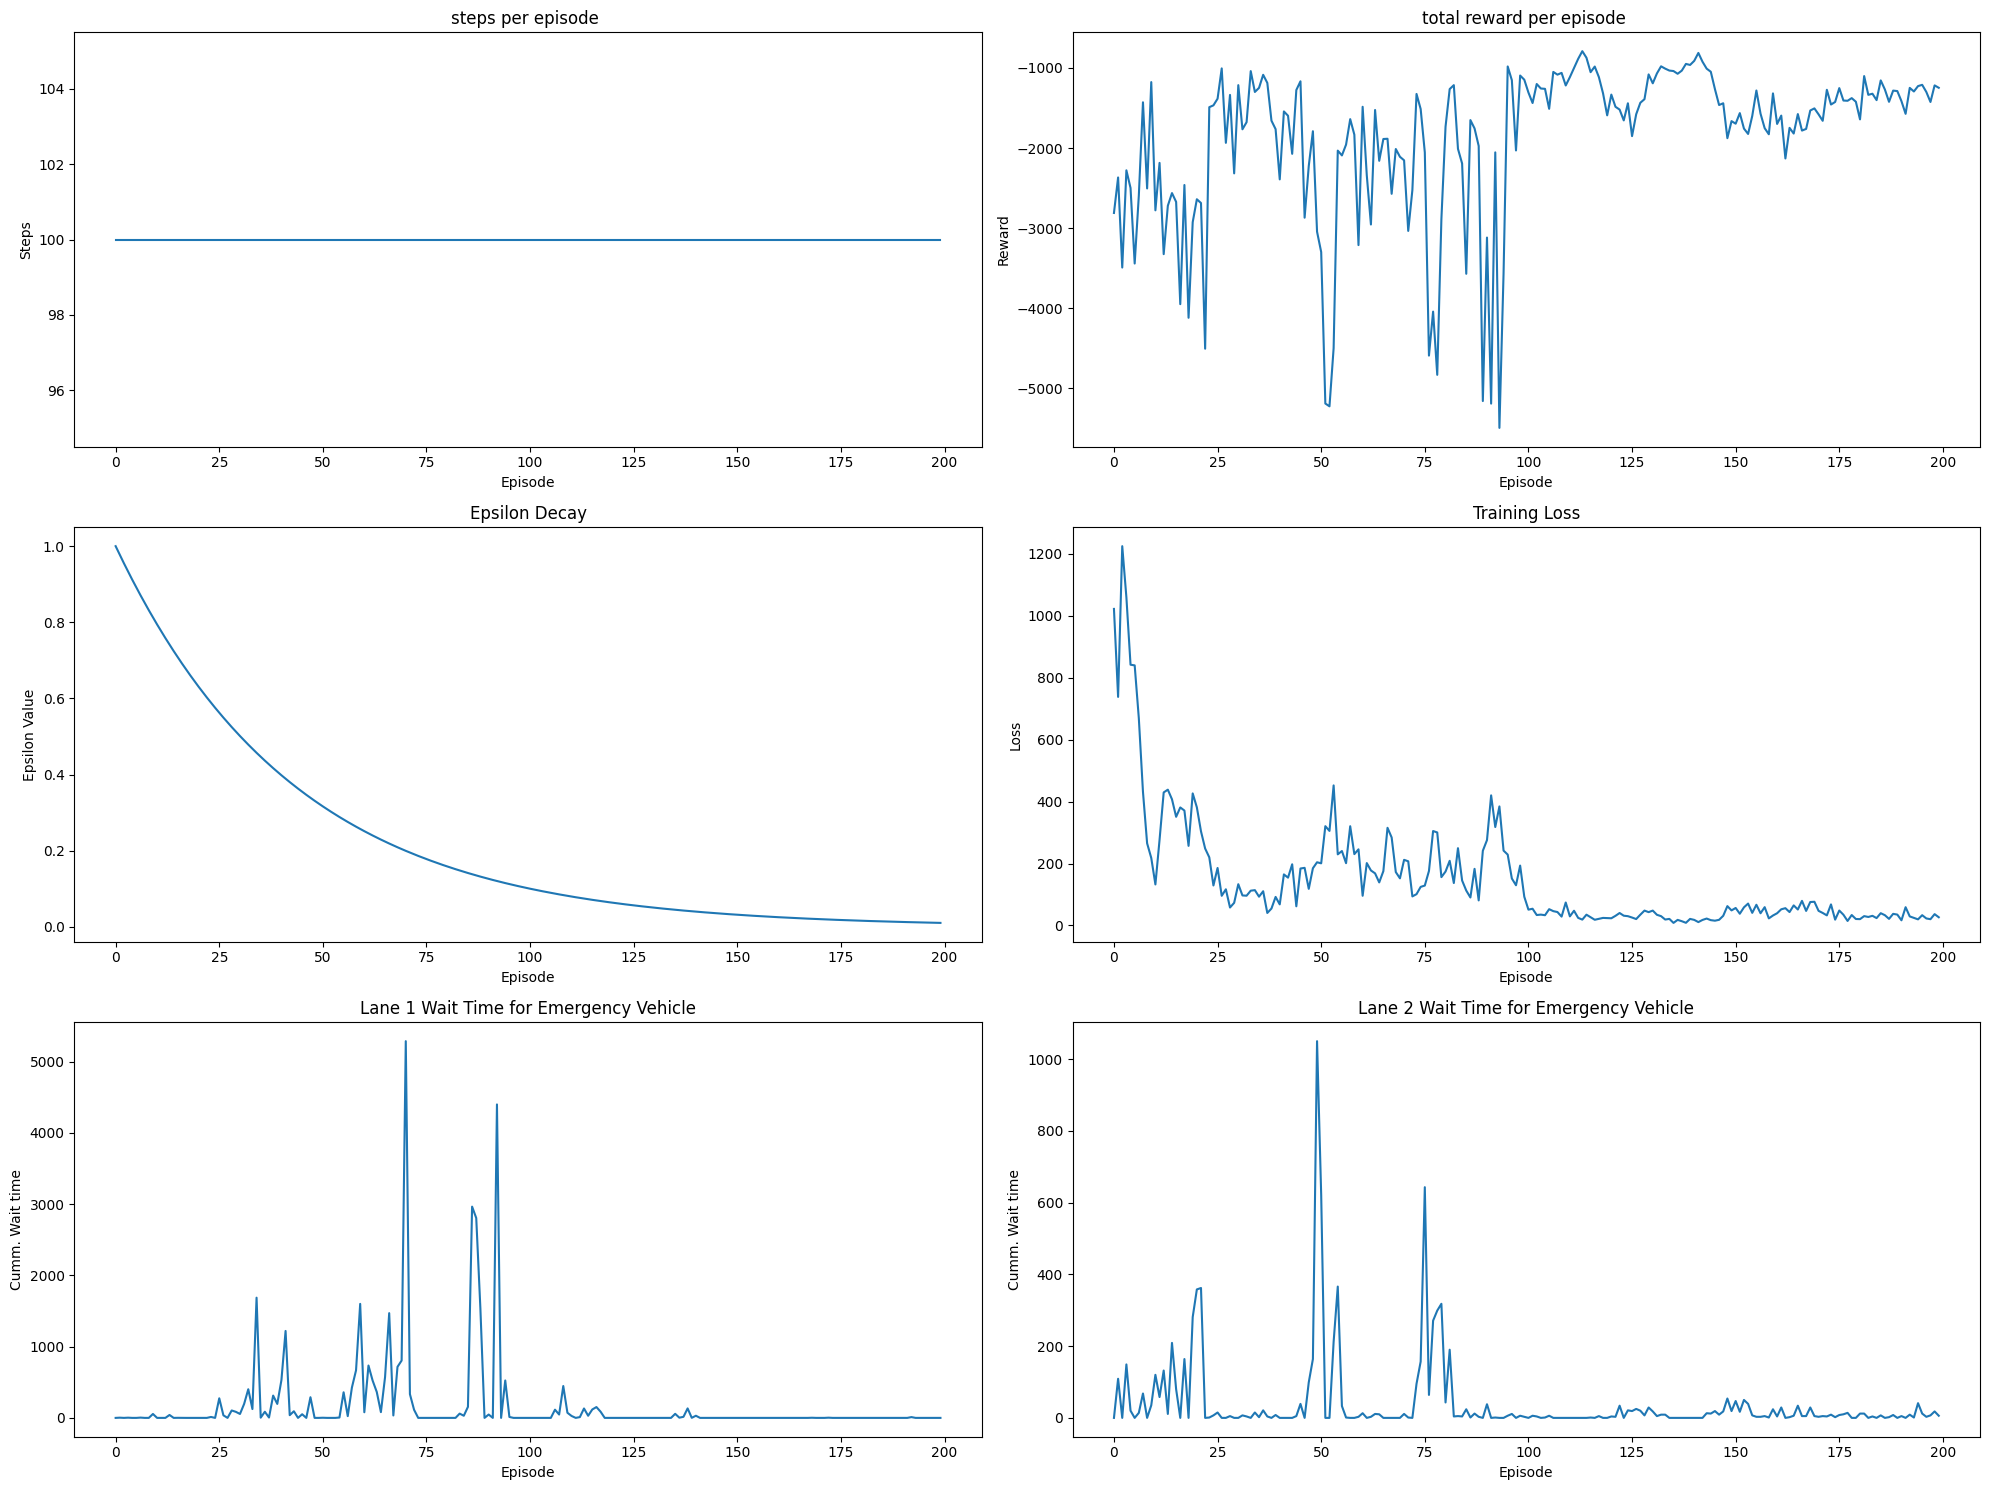

In [8]:
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

axs[0, 0].plot(range(episodes), steps_per_episode)
axs[0, 0].set_title("steps per episode ")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Steps")

axs[0, 1].plot(range(episodes), reward_per_episode)
axs[0, 1].set_title("total reward per episode ")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(range(episodes), epsilon_per_episode)
axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Epsilon Value")

axs[1, 1].plot(range(len(train_loss)), train_loss)
axs[1, 1].set_title("Training Loss")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Loss")

axs[2, 0].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[2, 0].set_title("Lane 1 Wait Time for Emergency Vehicle")
axs[2, 0].set_xlabel("Episode")
axs[2, 0].set_ylabel("Cumm. Wait time")

axs[2, 1].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2, 1].set_title("Lane 2 Wait Time for Emergency Vehicle")
axs[2, 1].set_xlabel("Episode")
axs[2, 1].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [9]:
n_episodes = 5
agent.epsilon = 0
reward_per_episode = [0]*n_episodes
wait_per_episode_lane_1 = [0] * n_episodes
wait_per_episode_lane_2 = [0] * n_episodes
for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, info = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v

 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 355 ACT 26 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 348 ACT 32 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 363 ACT 35 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 355 ACT 25 BUF 0)                 
 Retrying in 1 seconds


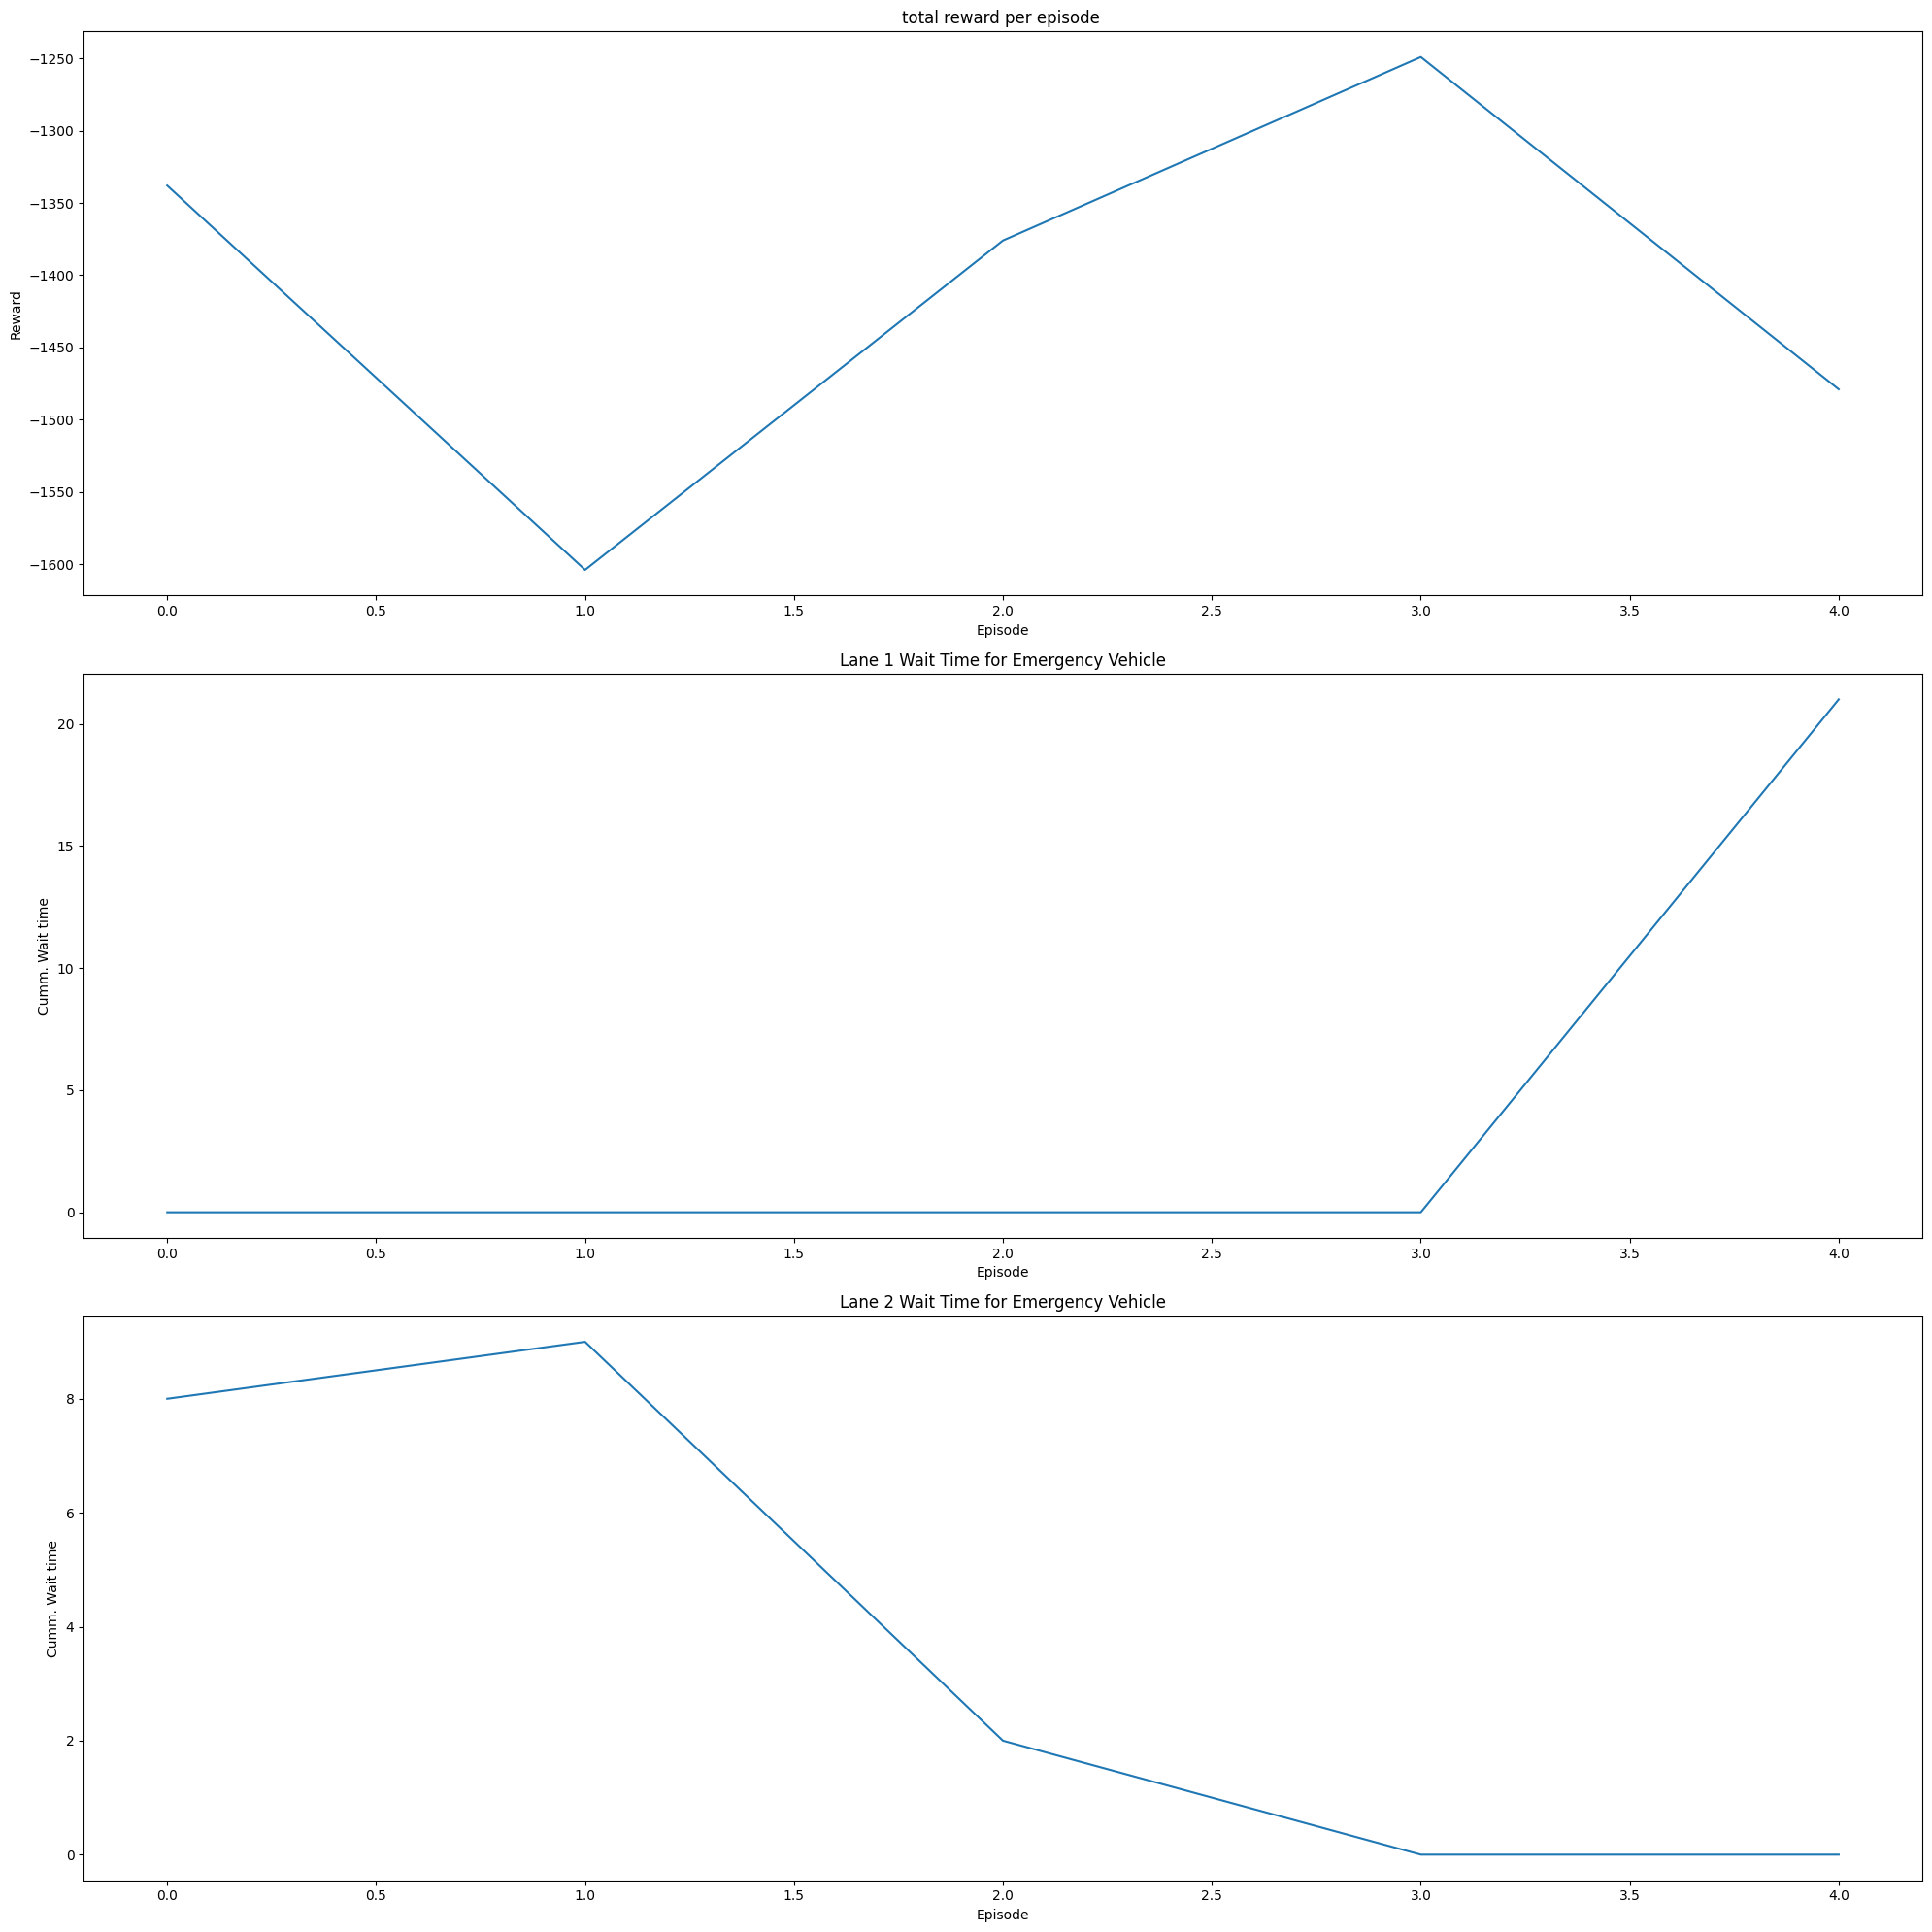

In [10]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

axs[0].plot(range(n_episodes), reward_per_episode)
axs[0].set_title("total reward per episode ")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[1].set_title("Lane 1 Wait Time for Emergency Vehicle")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumm. Wait time")

axs[2].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2].set_title("Lane 2 Wait Time for Emergency Vehicle")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [11]:
torch.save(model.state_dict(), "emergency_dqn.pth")

In [12]:
import traci

if traci.isLoaded():
    traci.close()

Step #500.00 (0ms ?*RT. ?UPS, TraCI: 200ms, vehicles TOT 352 ACT 31 BUF 0)                


In [17]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

n_episodes = 1
agent.epsilon = 0
reward_per_episode = [0]*n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, _ = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

 Retrying in 1 seconds


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


FatalTraCIError: Connection already closed.

In [14]:
# env = SumoEnvironment(
#         net_file="single-intersection/single-intersection.net.xml",
#         route_file="single-intersection/single-intersection.rou.xml",
#         out_csv_name="out_csv",
#         use_gui=True,
#         num_seconds=500,
#         min_green=5,
#         max_green=10,
#         observation_class = CustomEmergencyObservationFunction,
#         reward_fn = emergency_reward_fn
#     )

# n_episodes = 1
# for episode in range(n_episodes):
#     obs = env.reset()
#     done = {"__all__": False}
#     while not done["__all__"]:
#         next_obs, reward, done, _ = env.step({})